# 1. Setting Up

## 1.1 Libraries and Functions

In [813]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [814]:
# evaluate prediction on test set (meter/sec)
def evaluate(model, X_test):
    y_pred = model.predict(X_test)
    res = list(y_pred - y_test)
    MSE = mean_squared_error(y_test, y_pred)
    print("Number of predictions:", len(y_pred))
    print("MSE:", MSE)
    print("Mean:", np.mean(res))
    print("Std:", np.std(res))

In [ ]:
# evaluate prediction for rf
def evaluate_rf(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MAPE = {:0.2f}%.'.format(mape), '\n')
    
    return accuracy

In [815]:
# plot prediction result
def plot_res(model, X_test, title, fname):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.scatter(y_test, model.predict(X_test), color='steelblue', alpha=0.3)
    ax.plot([0,10], [0,10], 'indianred', linestyle=':')

    plt.xlabel("Actual Speed (m/s)", fontsize=14)
    plt.ylabel("Predicted Speed (m/s)", fontsize=14)
    plt.title("%s Prediction"%title, fontsize=18)

    plt.savefig("output/%s.png"%fname, dpi=300)
    plt.show()

## 1.2 Data Wrangling

In [816]:
df = pd.read_csv("bus_train.csv", index_col=0)
df.head()

,Timestamp_x,segment_id,BusLane_x,DayOfWeek_x,Holiday_x,HalfHourly,timeinseconds,intersections_x,busstops_x,AvgSpeed
NewVehicleRef,,,,,,,,,,
MTA NYCT_3828_1,2018-04-21 17:32:06.404000-04:00,1,False,6,1,3,63126,11,4,2.297799
MTA NYCT_3828_1,2018-04-27 18:38:40.371000-04:00,1,True,5,0,5,67120,11,4,3.013069
MTA NYCT_3828_1,2018-05-01 17:02:12.294000-04:00,1,True,2,0,2,61332,11,4,2.941267
MTA NYCT_3828_1,2018-04-21 17:37:56.484000-04:00,2,False,6,1,3,63476,15,5,1.005892
MTA NYCT_3828_1,2018-04-27 18:42:20.961000-04:00,2,True,5,0,5,67340,15,5,2.848134


In [817]:
df.columns

Index(['Timestamp_x', 'segment_id', 'BusLane_x', 'DayOfWeek_x', 'Holiday_x',
       'HalfHourly', 'timeinseconds', 'intersections_x', 'busstops_x',
       'AvgSpeed'],
      dtype='object')

In [818]:
# rename columns
df.columns = ['timestamp', 'segment', 'buslane', 'dayofweek', 'holiday',
              'halfhourly', 'timeinseconds', 'intersections', 'busstops', 'avgspeed']
df.shape

(3262, 10)

In [819]:
# number and percentage of records with negative speeds
len(df[df['avgspeed'] < 0]), len(df[df['avgspeed'] < 0]) / len(df) * 100

(8, 0.2452483139178418)

In [820]:
# remove negative speeds
df = df[df['avgspeed'] > 0]
df.shape

(3215, 10)

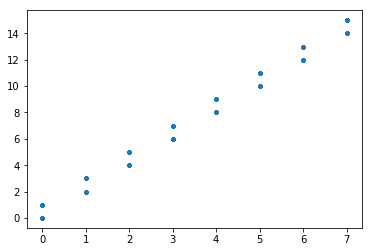

In [821]:
# redo time span partition if needed (or use halfhourly by default)
df['timespan'] = pd.cut(df.timeinseconds, range(57600, 73800, 900), right=False, labels=False)
# visually check if the partition is correct
plt.plot(df['halfhourly'], df['timespan'], '.')

## 1.3 Preparing train and test X-y datasets

In [822]:
# create X and y
X = df[['segment', 'buslane', 'dayofweek', 'holiday',
        'timespan', 'intersections', 'busstops']]
y = df['avgspeed']

X.head()

,segment,buslane,dayofweek,holiday,timespan,intersections,busstops
NewVehicleRef,,,,,,,
MTA NYCT_3828_1,1,False,6,1,6,11,4
MTA NYCT_3828_1,1,True,5,0,10,11,4
MTA NYCT_3828_1,1,True,2,0,4,11,4
MTA NYCT_3828_1,2,False,6,1,6,15,5
MTA NYCT_3828_1,2,True,5,0,10,15,5


In [823]:
# pre-process for better results for neural networks
X_pp = preprocessing.scale(X)

In [824]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2018)
# split dataset (pre-processed)
X_train_pp, X_test_pp, y_train, y_test = train_test_split(X_pp, y, test_size = 0.3, random_state = 2018)

# 2. Random Forest
pre-processing not required

In [825]:
# train model
rf = RandomForestRegressor(max_depth=10, n_estimators=80, n_jobs=-1, max_leaf_nodes=30, random_state=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=30,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

In [826]:
evaluate(rf, X_test)

Number of predictions: 965
MSE: 0.7990786603162741
Mean: -0.00899690466379094
Std: 0.8938667216217107


In [827]:
# examine feature importance
print(rf.feature_importances_)

[0.36283247 0.16130697 0.13223295 0.00270628 0.30082466 0.03467669
 0.00541997]


In [828]:
# cross-reference
X.columns

Index(['segment', 'buslane', 'dayofweek', 'holiday', 'timespan',
       'intersections', 'busstops'],
      dtype='object')

In [829]:
# try to predict a random segment
print(rf.predict([[3, 1, 2, 0, 8, 16, 6]]))

[2.03045058]


In [830]:
# predict the same segment on weekend instead
print(rf.predict([[3, 0, 7, 1, 8, 16, 6]]))

[2.76273354]


In [831]:
# tune hyper-parameters using a random search
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 100, 12)]
# Maximum number of
max_leaf_nodes = [int(x) for x in np.linspace(2, 70, 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'max_leaf_nodes': max_leaf_nodes,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#print(random_grid)

In [832]:
# random search with 3-fold cross validation
# search across 100 different combinations with all available cores
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=200, cv=3, verbose=False, random_state=2018, n_jobs=-1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 11, 20, 29, 38, 47, 55, 64, 73, 82, 91, 100], 'max_leaf_nodes': [2, 9, 17, 24, 32, 39, 47, 54, 62, 70], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=2018, refit=True,
          return_train_score=True, scoring=None, verbose=False)

In [833]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 11,
 'max_features': 'sqrt',
 'max_leaf_nodes': 39,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 52}

In [834]:
# evaluate random search performance
base_model = rf
base_model.fit(X_train, y_train)
base_accuracy = evaluate_rf(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate_rf(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.6510 degrees.
Accuracy = 58.27%.
MAPE = 41.73%. 

Model Performance
Average Error: 0.5894 degrees.
Accuracy = 59.65%.
MAPE = 40.35%. 

Improvement of 2.38%.


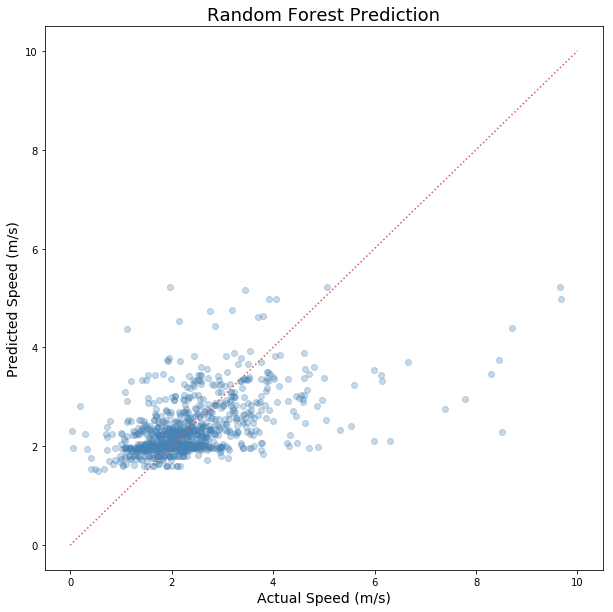

In [835]:
plot_res(best_random, X_test, "Random Forest", "rf")

# 3. Linear Regression

## 3.1 OLS

In [836]:
# smf provides summary
# lm = smf.ols(formula='avgspeed ~ C(segment) + C(buslane) + C(dayofweek) + C(holiday) + C(timespan) + intersections + busstops', data=df).fit()
# lm.summary()

In [837]:
OLS = linear_model.LinearRegression(fit_intercept=True)
OLS.fit(X_train, y_train)
predicted = OLS.predict(X_test)

R2_IS = OLS.score(X_train, y_train)
R2_OS = OLS.score(X_test, y_test)

print("R-squared for IS OLS is: {0}".format(R2_IS))
print("R-squared for OS OLS is: {0}".format(R2_OS))

R-squared for IS OLS is: 0.22953681819803917
R-squared for OS OLS is: 0.1876978476105674


## 3.2 Lasso

In [838]:
lasso_alpha = 0.0001
Lasso = linear_model.Lasso(fit_intercept=True, alpha=lasso_alpha)
Lasso.fit(X_train, y_train)

R2_IS = Lasso.score(X_train, y_train)
R2_OS = Lasso.score(X_test, y_test)

print("R-squared for IS Lasso is: {0}".format(R2_IS))
print("R-squared for OS Lasso is: {0}".format(R2_OS))

R-squared for IS Lasso is: 0.22953659310212693
R-squared for OS Lasso is: 0.18768026019092576


## 3.3 Ridge

In [839]:
ridge_alpha = 42
Ridge = linear_model.Ridge(fit_intercept=True, alpha=ridge_alpha)
Ridge.fit(X_train, y_train)

R2_IS = Ridge.score(X_train, y_train)
R2_OS = Ridge.score(X_test, y_test)

print("R-squared for IS Lasso is: {0}".format(R2_IS))
print("R-squared for OS Lasso is: {0}".format(R2_OS))

R-squared for IS Lasso is: 0.22903374569141477
R-squared for OS Lasso is: 0.18843070762886283


In [840]:
# evaluate prediction on test set (meter/sec)
evaluate(Ridge, X_test)

Number of predictions: 965
MSE: 0.890549210836587
Mean: -0.014782272694389363
Std: 0.9435733650599595


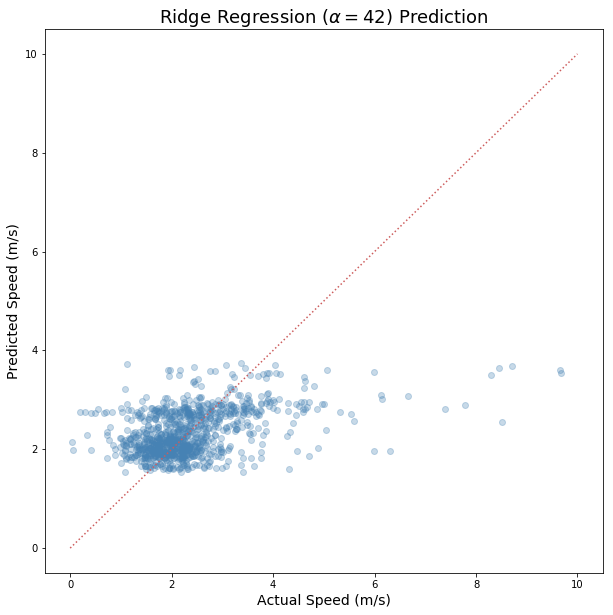

In [841]:
plot_res(Ridge, X_test, "Ridge Regression ($\\alpha=42$)", "ridge")

# 4. Neural Network

In [842]:
# try removing outliers
#X_train = X_train[y_train < 6]
#y_train = y_train[y_train < 6]

In [843]:
nn = MLPRegressor(hidden_layer_sizes=(200,),
                  activation='relu',
                  solver='lbfgs',
                  learning_rate='adaptive',
                  max_iter=1000,
                  learning_rate_init=0.001,
                  alpha=0.01,
                  random_state=1009)
nn.fit(X_train_pp, y_train)

MLPRegressor(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1009,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [844]:
# report R^2 score
nn.score(X_train_pp, y_train)

0.5369096770212451

In [845]:
evaluate(nn, X_test_pp)

Number of predictions: 965
MSE: 0.9596905294449383
Mean: -0.01404494819251148
Std: 0.979537272836112


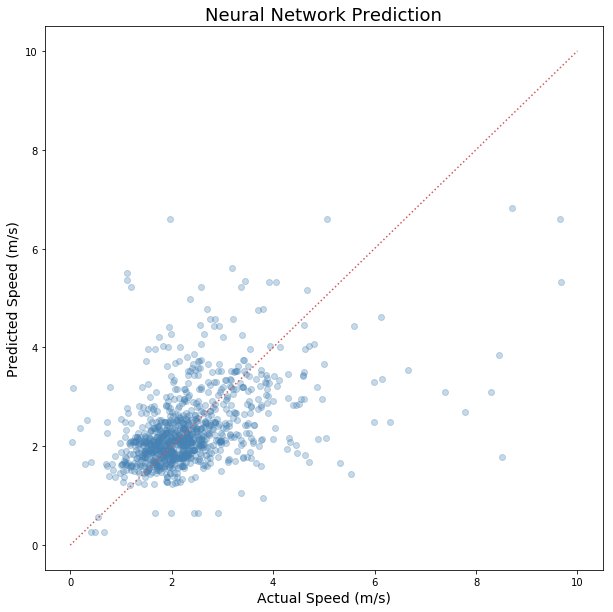

In [846]:
plot_res(nn, X_test_pp, "Neural Network", "nn")

# 5. Comparison

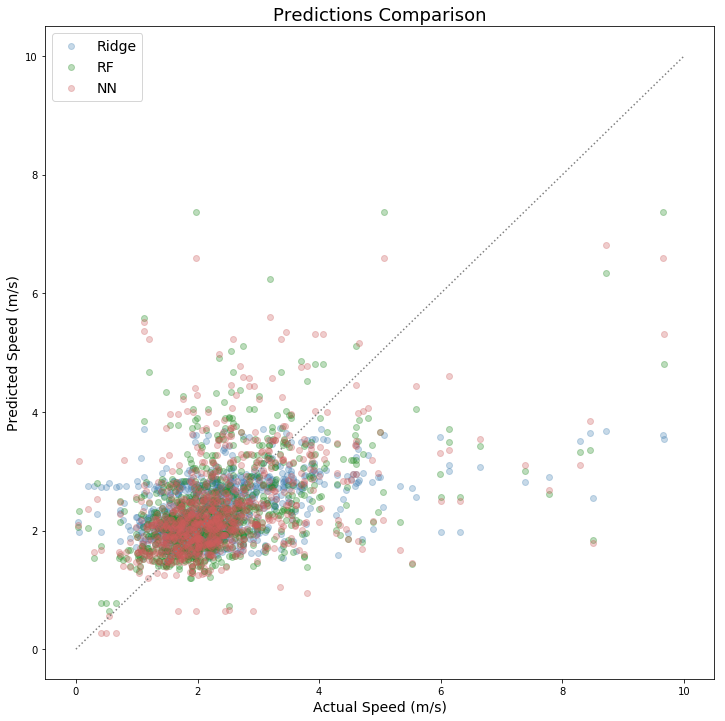

In [847]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.scatter(y_test, Ridge.predict(X_test), color='steelblue', marker='o', alpha=0.3, label='Ridge')
ax.scatter(y_test, rf.predict(X_test), color='forestgreen', marker='o', alpha=0.3, label='RF')
ax.scatter(y_test, nn.predict(X_test_pp), color='indianred', marker='o', alpha=0.3, label='NN')
ax.plot([0,10], [0,10], 'gray', linestyle=':')

plt.xlabel("Actual Speed (m/s)", fontsize=14)
plt.ylabel("Predicted Speed (m/s)", fontsize=14)
plt.title("Predictions Comparison", fontsize=18)
plt.legend(fontsize=14)

plt.savefig("output/all.png", dpi=300)
plt.show()